Final project

Group of at most 3 people

1. pick a data set and expalin what you want to predict
2. Clean the data, Scale it
3. Plot the data with PCA, and also with each features, and see if prediction would be possible
4. Remove correlated features
5. Test all the models and pick the best one (One of the same 5 train/test split - so you make 5 different X_train, X_test) and plot the results. Only use cross_validate to find
the best number of neighbors
6. Test the best model on another split with confusion matrix and plot, which features is important.
7. Train on the whole set with the best model and predict values you pick
8. Try an ensemble model and compare it to the best model
ensemble model - pick multiple models that predict something, and do the average/linear regression on those model's results

proj due december 1st

points for cleanliness

plots explaining dataset, how it looks, features, what you predict, clean it

find best mode, conf matrix

the more complex dataset, the more points its worth

same split, for cross validate

try to do a model we have not done

want boundary plot, feature importance

cares more about explanation than model or accuracy

remove nulls, if you can't pick the medians

convert yes/no strings to 0/1

know group and dataset before break



In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("reviews.csv")
df = df.drop(columns=["Unnamed: 0"])
df.describe()

,rating,seat_comfort,cabin_staff_service,food_and_beverages,inflight_entertainment,ground_service,wifi_and_connectivity,value_for_money,recommended,verified
count,1998.000000,1885.000000,1879.000000,1450.000000,1320.000000,1939.000000,1159.000000,1998.000000,1998.000000,1998.000000
mean,3.285786,2.485411,2.759979,2.487586,2.833333,2.195977,2.283865,2.097598,0.244244,0.679680
std,3.264797,1.436713,1.601841,1.466976,1.581099,1.569433,1.513785,1.487381,0.429746,0.466716
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,0.000000,1.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000


Initial analysis

In [33]:
for col in df.columns:
    print("Column name: " + col + " NAs: " + str(df[col].isna().sum()) + " Datatype: " + str(df[col].dtype))

Column name: rating NAs: 0 Datatype: int64
Column name: aircraft NAs: 1622 Datatype: object
Column name: type_of_traveller NAs: 0 Datatype: object
Column name: cabin_flown NAs: 0 Datatype: object
Column name: route NAs: 20 Datatype: object
Column name: date_flown NAs: 0 Datatype: object
Column name: seat_comfort NAs: 113 Datatype: float64
Column name: cabin_staff_service NAs: 119 Datatype: float64
Column name: food_and_beverages NAs: 548 Datatype: float64
Column name: inflight_entertainment NAs: 678 Datatype: float64
Column name: ground_service NAs: 59 Datatype: float64
Column name: wifi_and_connectivity NAs: 839 Datatype: float64
Column name: value_for_money NAs: 0 Datatype: float64
Column name: recommended NAs: 0 Datatype: int64
Column name: verified NAs: 0 Datatype: int64
Column name: review NAs: 0 Datatype: object


<Figure size 1000x1000 with 0 Axes>

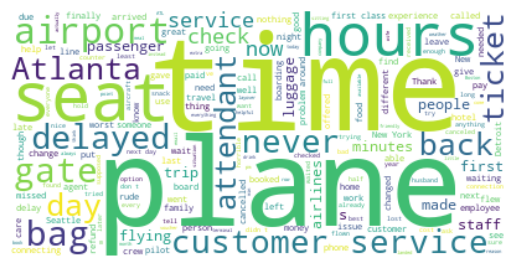

<Figure size 1000x1000 with 0 Axes>

In [4]:
#wordcloud
text = " ".join(review for review in df.review)

stopwords = set(STOPWORDS)
stopwords.update(["flight", "Delta", "one", "told", "took", "said", "two", "make", "given", "minute",
                  "asked", "still", "way", "hour", "will", "really", "u", "got", "without", "say", "better", "take",
                  "overall", "much", "return", "fly", "us", "even", "go", "getting", "airline", "flights", "another"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=[10,10])